In [1]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

In [2]:
import numpy as np
import torch
from torch import nn

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform
import population
import spectra_processing

import visualization

In [3]:
from reader import read_bruker_data
from BaselineRemoval import BaselineRemoval

In [4]:
from importlib import reload

reload(population)
reload(time_population)
reload(res_field_algorithm)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)

<module 'spin_system' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spin_system.py'>

# CW Spectra

In [5]:
path = r"D:\ITC\Эксперементы_на_ЭПР_спектрометре\2025_EPR\2025\MD5_NFFN_2mtgf_2025_03_20\MD5_NFFN_2mtgf_2025_03_20\CW\CW_36_db_90K_90K"
cw = read_bruker_data(path)

magnetic_field = cw[1]["x_values"] / 10_000
areas = [(0.320, 0.328), (0.343, 0.350)]
y_experiment, baseline = spectra_processing.correct_baseline(magnetic_field, cw[1]["y_values"], areas)
y_experiment = y_experiment / np.abs(y_experiment).sum()

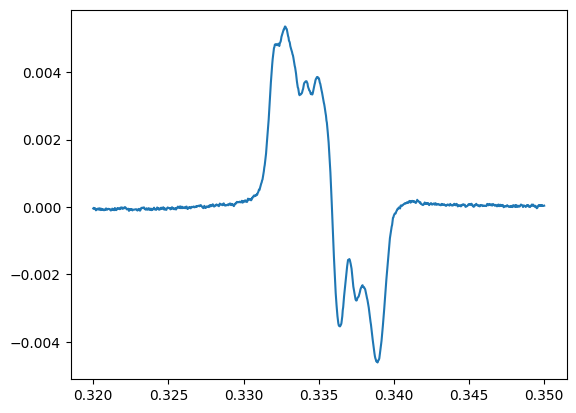

In [6]:
plt.plot(magnetic_field, y_experiment)

from importlib import reload

reload(population)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)### CW data fit

In [7]:
from importlib import reload
import typing as tp
import optimization
reload(population)
reload(optimization)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)

Some stuff might fail: issue in joblib
[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


<module 'spin_system' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spin_system.py'>

#### powder system creation

In [8]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, np.pi), initial_grid_frequency=30, interpolate=False)

def build_powder(params) -> spin_system.MultiOrientedSample:
        g_factor, D, E, h_strain, gauss, lorentz = params["g_factor"], params["D"], params["E"], params["h_strain"], params["gauss"], params["lorentz"]

        # g-tensor components
        zeem = spin_system.Interaction(g_factor)

        # Zero-field splitting calculations
        D_val = 2.0 * D
        E_val = 2.0 * E
        
        Dx = -1/3 * D_val + E_val
        Dy = -1/3 * D_val - E_val
        Dz = 2/3 * D_val
        
        J = -1.1
        J = -2 * J # Because -2 S1 S2
        J_hz = constants.unit_converter(J, "cm-1_to_Hz")
        
        components_dipole = torch.tensor([Dx, Dy, Dz]) + J_hz
        ee_int = spin_system.Interaction(components_dipole)

        e1 = particles.Electron(spin=0.5)
        e2 = particles.Electron(spin=0.5)
        
        system = spin_system.SpinSystem(
            electrons=[e1, e2],
            g_tensors=[zeem, zeem],
            electron_electron=[(0, 1, ee_int)]
        )
        return spin_system.MultiOrientedSample(system, h_strain, gauss, lorentz, mesh)
    
class SampleUpdator():
    def __init__(self, sample):
        self.sample = sample
        
    def __call__(self, params) -> spin_system.MultiOrientedSample:
            g_factor, D, E, h_strain, gauss, lorentz = (params["g_factor"],
            params["D"], params["E"],
            params["h_strain"],
            params["gauss"], params["lorentz"])

            # g-tensor components
            zeem = spin_system.Interaction(g_factor)

            # Zero-field splitting calculations
            D_val = 2.0 * D
            E_val = 2.0 * E

            Dx = -1/3 * D_val + E_val
            Dy = -1/3 * D_val - E_val
            Dz = 2/3 * D_val

            J = 1.1
            J = -2 * J # Because -2 S1 S2
            J_hz = constants.unit_converter(J, "cm-1_to_Hz")

            components_dipole = torch.tensor([Dx, Dy, Dz]) + J_hz
            ee_int = spin_system.Interaction(components_dipole)

            e1 = particles.Electron(spin=0.5)
            e2 = particles.Electron(spin=0.5)

            system = spin_system.SpinSystem(
                electrons=[e1, e2],
                g_tensors=[zeem, zeem],
                electron_electron=[(0, 1, ee_int)]
            )
            self.sample.update(g_tensors = [zeem, zeem], electron_electron=[(0, 1, ee_int)], ham_strain=h_strain,lorentz=lorentz,gauss=gauss)
            return sample

In [9]:
g_factor = optimization.ParamSpec(name="g_factor", bounds=(2.0, 2.02), default=2.005)
D = optimization.ParamSpec(name="D", bounds=(75*1e6, 95*1e6), default=90*1e6)
E = optimization.ParamSpec(name="E", bounds=(25*1e6, 40*1e6), default=30*1e6)
gauss = {"gauss": 0.0}
lorentz = optimization.ParamSpec(name="lorentz", bounds=(0.00, 0.003), default=0.001)
h_strain = optimization.ParamSpec(name="h_strain", bounds=(1e7, 1e8), default=3e7)

param_space = optimization.ParameterSpace(specs=[g_factor, D, E, lorentz, h_strain], fixed_params=gauss)

In [10]:
sample = build_powder(dict(param_space))
spec_creator = spectra_manager.StationarySpectraCreator(freq=cw[0]["MWFQ"], sample=sample)
with torch.no_grad():
    spec = spec_creator(sample, torch.tensor(magnetic_field, dtype=torch.float32))

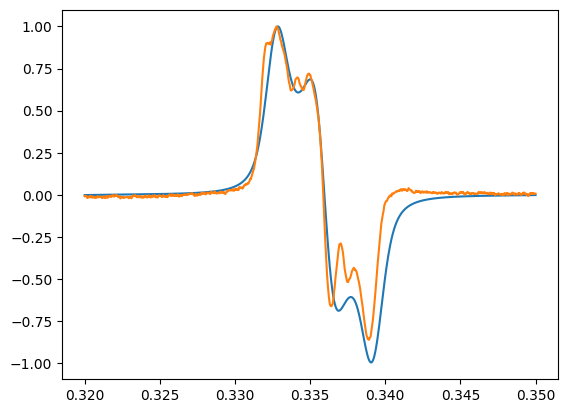

In [11]:
plt.plot(magnetic_field, spec.numpy() / max(spec.numpy()))
plt.plot(magnetic_field, y_experiment / max(y_experiment))

In [12]:
simulator = optimization.CWSpectraSimulator(sample_updator=SampleUpdator(sample), spectra_creator=spec_creator)

In [13]:
fitter = optimization.SpectrumFitter(x_exp=magnetic_field, y_exp=y_experiment, param_space=param_space, spectra_simulator=simulator)
study = fitter.fit(backend="optuna", n_trials=100)

[I 2025-09-05 16:15:41,662] A new study created in memory with name: no-name-4c8351a4-b6e4-446b-a22d-aabf9f9dd559


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
best_params = study.best_params
new_param_space = param_space.copy()
new_param_space.set_default(best_params)
new_param_space.reduce_bounds(param_space.varying_names, alpha=0.3)
fitter.param_space = new_param_space
new_result = fitter.fit(backend="ng", budget=10, optimizer_name="Cobyla")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.26it/s]

Step 10: Loss = 0.076068


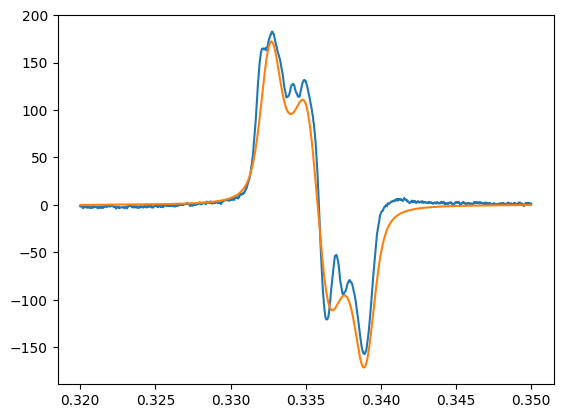

In [15]:
plt.plot(fitter.x_exp.numpy(), fitter.y_exp.numpy())
plt.plot(fitter.x_exp.numpy(), new_result.best_spectrum.numpy())

In [16]:
new_result.best_params

{'g_factor': 2.005988165622411,
 'D': 84405306.59208493,
 'E': 34649268.72955904,
 'lorentz': 0.0008447476005907207,
 'h_strain': 25412889.297064185}

In [17]:
params = {'g_factor': 2.006431161587136,
 'D': 84409080.29358856,
 'E': 35719921.72223483,
 'lorentz': 0.00020491651888303826,
 'h_strain': 36050648.73003518}

In [18]:
param_space.set_default(params)
sample = build_powder(param_space)

### Experemental Part Preparation T1

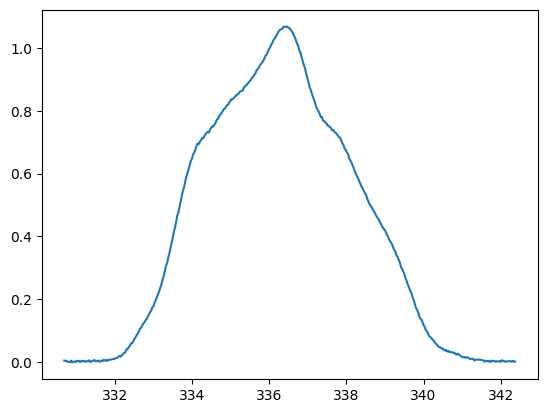

In [19]:
folder_path = r"D:\ITC\Эксперементы_на_ЭПР_спектрометре\2025_EPR\2025\MD5_NFFN_2mtgf_2025_03_20\MD5_NFFN_2mtgf_2025_03_20\7K"
spectra_name = r"\field_dep_7K_50_100_340_4reps_vidg_4db_atten_10dB_35ms"
spectra_path = folder_path + spectra_name
spectra_temp_7K = read_bruker_data(spectra_path)

x_vals = spectra_temp_7K[1]["x_values"]
y_vals = spectra_temp_7K[1]["y_values"]

y_vals, baseline = spectra_processing.correct_baseline(x_vals, y_vals, baseline_areas=((3250, 3300), (3450, 3500)))
y_vals, _ = spectra_processing.signal_to_amplitude(y_vals)


idx_start = 330
idx_end = 730
y_experement = np.real(y_vals)[idx_start:idx_end] / 25_000
x_experement = x_vals[idx_start:idx_end] / 10

plt.figure()

plt.plot(x_experement, y_experement)

### Copmutation Part Preparation

In [20]:
param_space.set_default(params)

In [21]:
powder = build_powder(param_space)

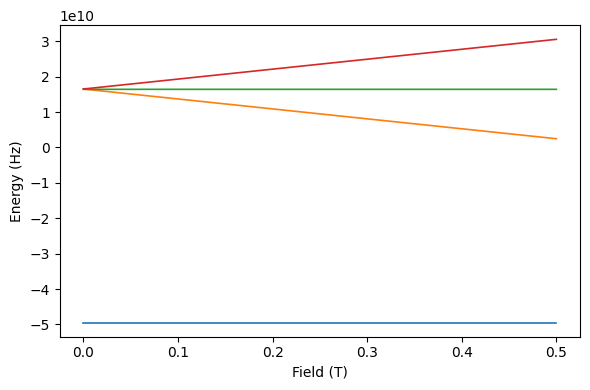

In [22]:
F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
B = torch.linspace(0.0, 0.500, 200)
B = B[..., None, None]
orient_hams = F[0] + B *Gz[0] 
energies, vectors = torch.linalg.eigh(orient_hams)

import matplotlib.pyplot as plt
levels_plot.plot_energy_system(B, energies, vectors, [0,1,2,3], False)

zero_ham = F[0]
zero_energies, zero_vectors = torch.linalg.eigh(zero_ham)

In [23]:
energies, vectors = torch.linalg.eigh(Gz*1 + F)

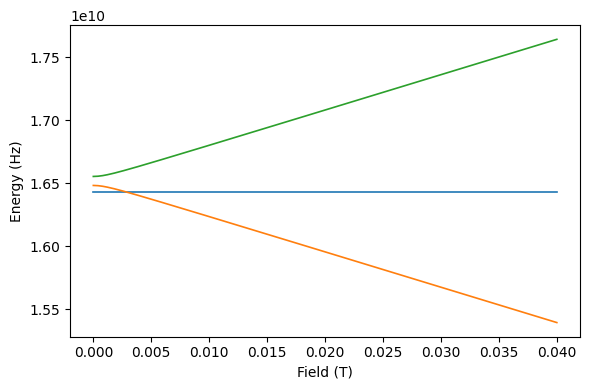

In [24]:
F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
B = torch.linspace(0.0, 0.04, 200)
B = B[..., None, None]
orient_hams = F[0] + B *Gz[0] 
energies, vectors = torch.linalg.eigh(orient_hams)

B = torch.linspace(0.0, 0.04, 200)
visualization.levels_plot.plot_energy_system(B, energies, vectors, levels=[1,2,3], saved_order=True)

In [25]:
reload(spectra_manager)
import spectral_integration
reload(spectral_integration)

zero_ham = F
zero_energies, zero_vectors = torch.linalg.eigh(zero_ham)

In [26]:
from math import sqrt

def get_levels_determination(vectors: torch.Tensor):
    
    Tx = (1 /sqrt(2)) * torch.tensor([1, 0.0, 0.0, -1.0], dtype=torch.complex64)
    Ty = (1.0j /sqrt(2)) * torch.tensor([1.0, 0.0, 0.0, 1.0], dtype=torch.complex64)
    Tz = (1 /sqrt(2)) * torch.tensor([0.0, 1, 1, 0.0], dtype=torch.complex64)
    T0 = (1 /sqrt(2)) * torch.tensor([0.0, -1, 1, 0.0], dtype=torch.complex64)
    
    basis_vectors = torch.stack([Tx, Ty, Tz, T0], dim=-1)
    basis_names = ["Tx", "Ty", "Tz", "T0"]
    
    closest_levels = []
    
    
    for i in range(vectors.shape[1]):
        
        eigenvector = vectors[:, i]
        eigenvector = eigenvector / torch.norm(eigenvector)
        
        overlaps = torch.abs(torch.sum(basis_vectors.conj().transpose(-1, -2) * eigenvector, dim=1))
        
        
        max_overlap_idx = torch.argmax(overlaps).item()
        closest_levels.append(basis_names[max_overlap_idx])
    return closest_levels

print(zero_vectors[0]), print("----"), print(get_levels_determination(zero_vectors[0]))

tensor([[ 0.0000+0.j,  0.0000+0.j, -0.7071-0.j, -0.7071+0.j],
        [-0.7071+0.j, -0.7071+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.7071+0.j, -0.7071+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.7071+0.j, -0.7071+0.j]])
----
['T0', 'Tz', 'Tx', 'Ty']


(None, None, None)

### Построим Фит T1 кривых через kx, ky, kz, probs.

In [27]:
freq = 9.445 * 1e9
res_freq = torch.tensor(freq)  
magnetic_field = torch.tensor([330, 333, 334, 335, 336, 337, 338, 339.4, 339.7, 350]) / 1000


T1 = torch.tensor([0.53, 0.52, 0.32, 0.30, 0.32, 0.40, 0.80, 0.97]) * 1e-3
gamma = torch.tensor(0.55)

magnetic_field = torch.tensor([330, 333, 334, 335, 336, 337, 338, 339.4, 339.7, 350]) / 1000
size = 200

T1 = torch.tensor([0.53, 0.52, 0.32, 0.30, 0.32, 0.40, 0.80, 0.97]) * 1e-3
gamma = torch.tensor(0.55)
time = torch.linspace(0.0, 30 * 1e3, size) * 1e-6

##### Попробуем самостоятельно это сделать. Нужно определить 3 объекта: Context, Populator, MatrixGenerator

1. MatrixGenerator - объект, который принимает время и возвращает температуру, вероятности переходов

2. Populator - объект, который задаёт механизм релаксации

3. Context - dataclass с разной информацией о системе

In [28]:
import copy
from population import mechanisms
from dataclasses import dataclass

class ConstTempTripletMechanismGenerator(tr_utils.TransitionMatrixGenerator):
    def __init__(self, context: tp.Any, temp: torch.Tensor, system_vectors: torch.Tensor):
        self.temp = temp
        self.context = context
        self.basis_coeffs = transform.get_transformation_coeffs(
            context.zero_field_vectors.unsqueeze(-3),
            system_vectors
        )
        
        self.probs = self._compute_probs(
            context.transform_probs,
            context.free_probs
        )

    def _compute_probs(self,
                       free_probs_transform: torch.Tensor,
                       free_probs: torch.Tensor,
                       basis_coeffs: torch.Tensor | None = None) -> torch.Tensor:
        if basis_coeffs is None:
            basis_coeffs = self.basis_coeffs
        transformed_probs = transform.transform_rates_matrix(free_probs_transform, basis_coeffs)
        return transformed_probs + free_probs

    def _base_transition_probs(self, temp: torch.Tensor | None) -> torch.Tensor:
        """Return the free transition probabilities at given temperature(s)"""
        return self.probs

    def _temperature(self, time: torch.Tensor) -> torch.Tensor | None:
        """Return temperature(s) at times t"""
        return self.temp

class T1Population(time_population.BaseTimeDependantPopulator):
    """
    Computes the T1 relaxation of a spin system.
    It changes the populations of the transition levels and measure relaxation of population
    """
    def __init__(self,
                 context: tp.Any,
                 tr_matrix_generator_cls: tp.Type[tr_utils.TransitionMatrixGenerator],
                 solver: tp.Callable = tr_utils.EvolutionVectorSolver.odeint_solver,
                 init_temp: float = 300):
        """
        :param init_temp: temperature in K
        """
        super().__init__(context, tr_matrix_generator_cls, solver, init_temp)

    def _post_compute(self, time_intensities: torch.Tensor, *args, **kwargs):
        """
        :param time_intensities: The population difference between transitioning energy levels depending on time.
            The shape is [time, ....]
        :return: intensity of transitions due to population difference
        """
        return time_intensities - time_intensities[-1].unsqueeze(0)

    def _initial_populations(self, energies: torch.Tensor,
                             lvl_down: torch.Tensor,
                             lvl_up: torch.Tensor,
                             *args, **kwargs):
        populations = nn.functional.softmax(-constants.unit_converter(energies) / self.init_temp, dim=-1)
        new_populations = copy.deepcopy(populations)
        indexes = torch.arange(energies.shape[-2], device=energies.device)
        new_populations[..., indexes, lvl_down] = populations[..., indexes, lvl_up]
        new_populations[..., indexes, lvl_up] = populations[..., indexes, lvl_down]
        return new_populations

    def _init_tr_matrix_generator(self,
                                  time: torch.Tensor,
                                  res_fields: torch.Tensor,
                                  lvl_down: torch.Tensor,
                                  lvl_up: torch.Tensor,
                                  vector_down: torch.Tensor,
                                  vector_up: torch.Tensor,
                                  energies: torch.Tensor, *args, **kwargs):
        full_system_vectors = args[0]
        tr_matrix_generator = self.tr_matrix_generator_cls(self.context, self.init_temp, args[0])
        return tr_matrix_generator

In [29]:
@dataclass
class TripletMechanismContext():
    zero_field_vectors: torch.Tensor
    transform_probs: tp.Union[torch.Tensor, tp.Callable[[torch.Tensor], torch.Tensor]]
    free_probs: tp.Union[torch.Tensor, tp.Callable[[torch.Tensor], torch.Tensor]]
    
def get_context(params):
    k_x, k_y, k_z, triplet_prob = params["k_x"], params["k_y"], params["k_z"], params["triplet_prob"]

    free_probs = torch.tensor([[0.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, triplet_prob, 0.0],
                      [0.0, triplet_prob, 0.0, triplet_prob],
                      [0.0, 0.0, triplet_prob, 0.0]
                      ])

    transform_probs =torch.tensor([
        [0, k_z, k_y, k_x],
        [k_z, 0, 0.0, 0.0],
        [k_y, 0.0, 0, 0.0],
        [k_x, 0.0, 0.0, 0]
    ])


    config = TripletMechanismContext(
        zero_field_vectors = zero_vectors,
        transform_probs = transform_probs,
        free_probs = free_probs)
    
    return config

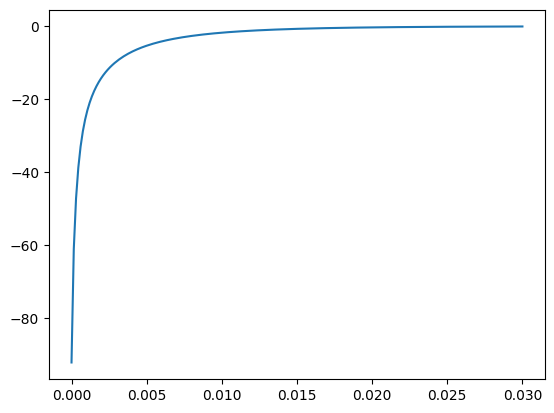

In [30]:
params = {
    'k_x': 20.37235554774663,
     'k_y': 145.42513282181963,
      'k_z': 8787.46130349088 ,
 'triplet_prob': 31.135674653876734}

context = get_context(params)
t1_populator = T1Population(context, ConstTempTripletMechanismGenerator, init_temp=7)
spectra_integrator = spectra_manager.CoupledSpectraCreatorTimeResolved(harmonic=0, populator=t1_populator, freq=res_freq, sample=sample)
with torch.no_grad():
    specs = spectra_integrator(sample, magnetic_field, time)
    
plt.plot(time.numpy(), specs[:, 0].numpy())

### Библиотека предоставляет уже готовые примеры мехнизмов релаксации
mechanisms

In [31]:
from population import mechanisms
reload(optimization)

reload(tr_utils)
reload(mechanisms)

<module 'population.mechanisms' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\population\\mechanisms.py'>

In [32]:
t1_populator = mechanisms.T1Population(init_temp=7.0, context=context, solver=tr_utils.EvolutionVectorSolver.stationary_rate_solver)
spectra_integrator = spectra_manager.CoupledSpectraCreatorTimeResolved(harmonic=0, populator=t1_populator, freq=res_freq, sample=sample)
with torch.no_grad():
    specs = spectra_integrator(sample, magnetic_field, time)

### Попробуем зафитировать параметры релаксации

1. Для этого уже были зафитированы параметры релаксации в разных магнитных полях в виде stretched экспоненты.
2. Теперь найдём k_x, k_y, k_z, triplet_prob через полученыне параметры T1, gamma

In [33]:
def scaled_time_curve(x, y):
    old_max = torch.max(y, dim=-1, keepdim=True)[0]
    old_min = torch.min(y, dim=-1, keepdim=True)[0]
    
    scaled = (y - old_min) / (old_max - old_min) - 1

    return  scaled

def theretical_curve(gamma: torch.Tensor, T1: torch.Tensor, time: torch.Tensor):
    y = -torch.exp(-torch.pow(time / T1, gamma))

    return scaled_time_curve(time, y)

T1 = torch.tensor([0.53, 0.52, 0.32, 0.30, 0.32, 0.40, 0.80, 0.97]) * 1e-3
gamma = torch.tensor(0.55)
magnetic_field = torch.tensor([330, 333, 334, 335, 336, 337, 338, 339.4, 339.7, 350]) / 1000
size = 200
time = torch.linspace(0.0, 30 * 1e3, size) * 1e-6

y_exp = []
for t1 in T1:
    y_exp.append(theretical_curve(gamma, t1, time))

In [34]:
k_x = optimization.ParamSpec(name="k_x", default=1e2, bounds=(10, 1e4))
k_y = optimization.ParamSpec(name="k_y", default=1e2, bounds=(10, 1e4))
k_z = optimization.ParamSpec(name="k_z", default=1e2, bounds=(10, 1e4))
triplet_prob = optimization.ParamSpec(name="triplet_prob", default=1e2, bounds=(10, 1e4)) 

param_relax_space = optimization.ParameterSpace(specs=[k_x, k_y, k_z, triplet_prob])

In [35]:
class SpectraSimulator:
    def __init__(self,
                 config_creator: tp.Callable[[dict[str, float], tp.Any], tp.Any], *args):
        self.config_creator = config_creator
        init_context =  self.config_creator(param_relax_space)
        t1_populator = mechanisms.T1Population(init_temp=7.0, context=init_context, solver=tr_utils.EvolutionVectorSolver().stationary_rate_solver)
        self.spectra_creator = spectra_manager.CoupledSpectraCreatorTimeResolved(harmonic=0, populator=t1_populator, freq=res_freq, sample=sample)
        self.args = args
        self.fields = torch.tensor([330, 333, 334, 335, 336, 337, 338, 339.4, 339.7, 350]) / 1000


    def __call__(self, time: torch.Tensor, params: dict[str, float]):
        config = self.config_creator(params, *self.args)
        self.spectra_creator.update_context(config)
        out = self.spectra_creator(sample, self.fields, time[0])
        return [out[:, i] - out[-1, i] for i in range(1, len(self.fields)-1)]

In [36]:
x_exp = [time for _ in range(len(y_exp))]

sim = SpectraSimulator(get_context)
fitter = optimization.SpectrumFitter(x_exp=x_exp, y_exp=y_exp, param_space=param_relax_space, spectra_simulator=sim, norm_mode="max")

In [37]:
study = fitter.fit(backend="optuna", n_trials=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
best_params = study.best_params
new_param_space = param_relax_space.copy()
new_param_space.set_default(best_params)
new_param_space.reduce_bounds(param_relax_space.varying_names, alpha=1e-2)

In [39]:
fitter.param_space = new_param_space
new_result = fitter.fit(backend="ng", budget=2, optimizer_name="Cobyla")

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.58it/s]


In [40]:
 study.best_spectrum[0].shape

torch.Size([200])

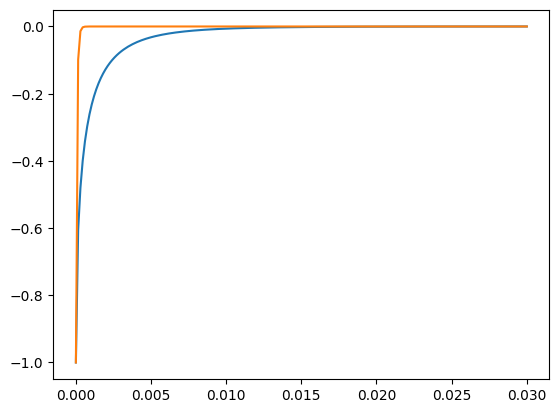

In [41]:
plt.plot(fitter.x_exp[0].numpy(), fitter.y_exp[0].numpy())
plt.plot(fitter.x_exp[0].numpy(), study.best_spectrum[0].numpy())

In [42]:
best_params_T1 = {'k_x': 19.40432703861892,
 'k_y': 10.129719594771128,
 'k_z': 9046.496879013306,
 'triplet_prob': 98.78081991553208}

### 1. Загрузим экспериментальные данные

In [43]:
import spectra_processing

def get_field(meta):
    return meta["CenterField"]['value']

folder_path = r"D:\ITC\Эксперементы_на_ЭПР_спектрометре\2025_EPR\2025\MD5_NFFN_2mtgf_2025_03_20\MD5_NFFN_2mtgf_2025_03_20\7K"


time_dep_3380gs = r"\T1\T1_7K_100_50_100ns_3380gs_40ms"
time_dep_3397gs = r"\T1\T1_7K_40_20_40ns_3397gs_40ms"
time_dep_3350gs = r"\T1\T1_7K_100_50_100ns_3350gs_35ms"
time_dep_3394gs = r"\T1\T1_7K_40_20_40ns_3394gs_40ms"
time_dep_3370gs = r"\T1\T1_7K_40_20_40ns_3370gs_35ms"

time_dep_3360gs = r"\T1\T1_7K_40_20_40ns_3360gs_35ms"
time_dep_3340gs = r"\T1\T1_7K_40_20_40ns_3340gs_35ms"
time_dep_3330gs = r"\T1\T1_7K_40_20_40ns_3330gs_35ms"

names = [
    time_dep_3380gs, time_dep_3397gs, time_dep_3350gs,
    time_dep_3394gs, time_dep_3370gs, time_dep_3360gs, time_dep_3340gs, time_dep_3330gs]

spectras = [read_bruker_data(folder_path + spectra_name) for spectra_name in names]

results = []
for spectra in spectras:
    y_vals = spectra[1]["y_values"]
    x_vals = spectra[1]["x_values"]
    field = get_field(spectra[0]) / 10
    y_vals, _ = spectra_processing.correct_baseline(x_vals, y_vals, method="saturation")
    y_vals, y_img = spectra_processing.signal_to_amplitude(y_vals)
    y_vals = -y_vals / y_vals[0]
    data = {"field": field, "x_vals": x_vals, "y_vals": y_vals}
    results.append(data)

In [44]:
y_model = fitter.simulate_spectroscopic_data(best_params_T1)

In [45]:
#y_exp = [y_exp[i] / 2 for i in range(len(y_exp))]

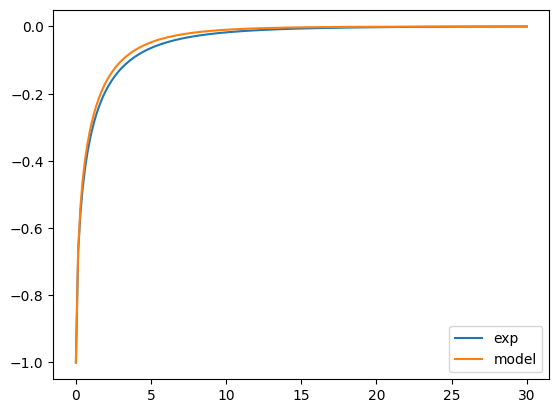

In [46]:
plt_time = time * 1e3

plt.plot(plt_time.numpy(), y_exp[-2].numpy(), label="exp")
plt.plot(plt_time.numpy(), y_model[-2].numpy(), label = "model")
plt.legend()

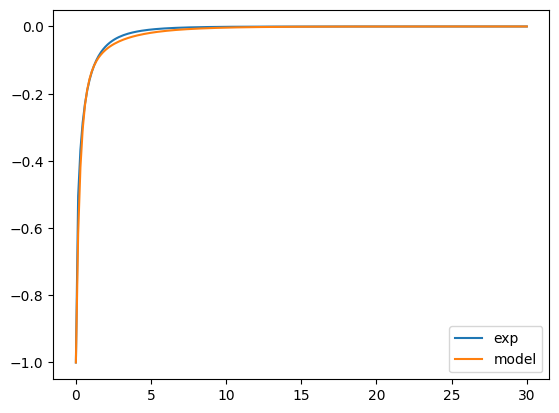

In [47]:
plt.plot(plt_time.numpy(), y_exp[3].numpy(), label="exp")
plt.plot(plt_time.numpy(), y_model[3].numpy(), label = "model")
plt.legend()

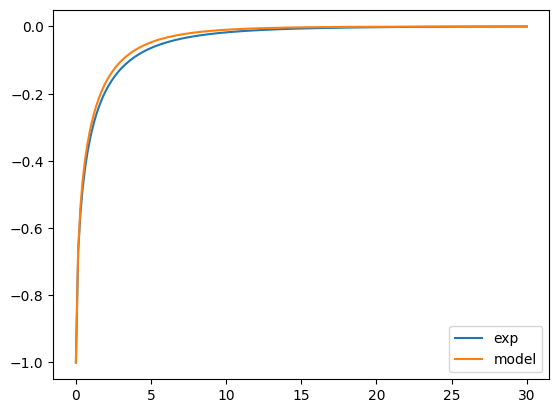

In [48]:
plt.plot(plt_time.numpy(), y_exp[6].numpy(), label="exp")
plt.plot(plt_time.numpy(), y_model[6].numpy(), label = "model")
plt.legend()

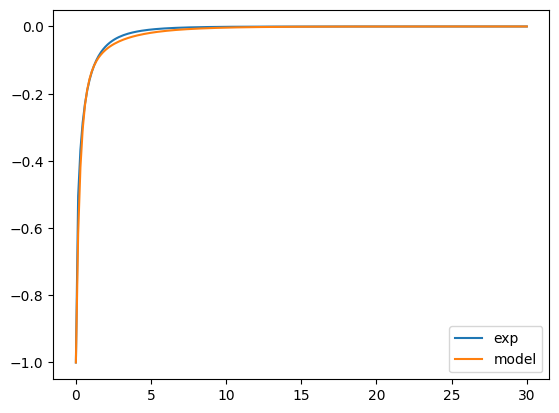

In [49]:
plt.plot(plt_time.numpy(), y_exp[3].numpy(), label="exp")
plt.plot(plt_time.numpy(), y_model[3].numpy(), label = "model")
plt.legend()

### Моделирование спектров время-разрешённого ЭПР

##### Время релаксации зависит, примерно, как 1/ температуру. Зададим зависимость коэффициентов релаксации, как линейную функцию от температуры

In [50]:
from population.temperature_dependance import profiles
from population import time_population, tr_utils, transform
import population
from population.temperature_dependance import rates
from importlib import reload


reload(population)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(rates)
reload(mechanisms)

reload(tr_utils)
reload(profiles)

<module 'population.temperature_dependance.profiles' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\population\\temperature_dependance\\profiles.py'>

In [51]:
zero_temp = torch.tensor(7.0)

best_params_T1 = {'k_x': 19.40432703861892,
 'k_y': 10.129719594771128,
 'k_z': 9046.496879013306,
 'triplet_prob': 98.78081991553208}

k_x = best_params_T1["k_x"]
k_y = best_params_T1["k_y"]
k_z = best_params_T1["k_z"]
triplet_prob = best_params_T1["triplet_prob"]

k_x_temp = rates.PowerRate(k_x / zero_temp, power=1)
k_y_temp = rates.PowerRate(k_y / zero_temp, power=1)
k_z_temp = rates.PowerRate(k_z / zero_temp, power=1)
triplet_prob_temp = rates.PowerRate(triplet_prob / zero_temp, power=1)


In [52]:
def get_context(params, temp):
    temp = torch.tensor(temp)
    k_x, k_y, k_z, triplet_prob = params["k_x"], params["k_y"], params["k_z"], params["triplet_prob"]
    
    k_x = k_x(temp)
    k_y = k_y(temp)
    k_z = k_z(temp)
    triplet_prob = triplet_prob(temp)

    free_probs = torch.tensor(
        [[0.0, 0.0, 0.0, 0.0],
         [0.0, 0.0, triplet_prob, 0.0],
         [0.0, triplet_prob, 0.0, triplet_prob],
         [0.0, 0.0, triplet_prob, 0.0]])

    transform_probs = torch.tensor([
        [0, k_z, k_y, k_x],
        [k_z, 0, 0.0, 0.0],
        [k_y, 0.0, 0, 0.0],
        [k_x, 0.0, 0.0, 0]
    ])

    config = TripletMechanismContext(
        zero_field_vectors = zero_vectors,
        transform_probs = transform_probs,
        free_probs = free_probs)
    
    return config

size = 400
time = torch.linspace(0.0, 60 * 1e3, size) * 1e-6
time_plt = time.numpy() * 1e3

zero_temp = torch.tensor(7.0)

best_params_T1 =\
{'k_x': 19.40432703861892,
 'k_y': 10.129719594771128,
 'k_z': 9046.496879013306,
 'triplet_prob': 98.78081991553208
}

k_x_temp = rates.PowerRate(k_x / zero_temp, power=1)
k_y_temp = rates.PowerRate(k_y / zero_temp, power=1)
k_z_temp = rates.PowerRate(k_z / zero_temp, power=1)
triplet_prob_temp = rates.PowerRate(triplet_prob / zero_temp, power=1)

params = {
 'k_x': k_x_temp,
 'k_y': k_y_temp,
 'k_z': k_z_temp,
 'triplet_prob': triplet_prob_temp
}
temp = 4.5
context = get_context(params, temp)

In [53]:
magnetic_field = torch.tensor([330, 334, 336, 339.0, 350]) / 1000

In [54]:
freq = 9.445 * 1e9
res_freq = torch.tensor(freq)        
with torch.no_grad():
    time_res_populator = mechanisms.T1Population(init_temp = temp, context=context)
    creator = spectra_manager.CoupledSpectraCreatorTimeResolved(sample=sample, populator=time_res_populator, freq=freq, harmonic=0)
    
    spec = creator(sample, magnetic_field, time=time)
    spec = spec[:, 1:-1]
    fields_t1 = magnetic_field[1:-1]


##### Сравним результат с кривыми Т1 при разных температурах

In [55]:
import re

def extract_temperatures_from_filenames(folder_path):
    """
    Extract full file paths and temperatures from files in the specified folder.
    
    Args:
        folder_path (str): Path to the folder containing files
    
    Returns:
        list: List of tuples (full_file_path, temperature_as_float)
    """
    file_temps = []

    temp_pattern = r'(\d+(?:p\d+)?K)(?:_(\d+(?:p\d+)?K)?)?'
    
    # Collect .dta files (assuming these are the primary files)
    dta_files = [f for f in os.listdir(folder_path) if f.endswith('.DTA')]
    
    for filename in dta_files:
        # Construct full file path
        full_path = os.path.join(folder_path, filename)
        
        # Extract temperatures
        match = re.search(temp_pattern, filename, re.IGNORECASE)
        if match:
            # Prefer the second temperature if it exists, otherwise use the first
            temp_str = match.group(2) or match.group(1)
            
            # Convert temperature string to float
            # Handle both 40p0K and 40K formats
            if 'p' in temp_str.lower():
                temp_float = float(temp_str.lower().replace('p', '.').rstrip('k'))
            else:
                temp_float = float(temp_str.lower().rstrip('k'))
            
            file_temps.append((full_path, temp_float))
    
    return file_temps

def get_field(meta):
    return meta["CenterField"]['value']

folder_path = r"D:\ITC\Эксперементы_на_ЭПР_спектрометре\2025_EPR\2025\MD5_NFFN_2mtgf_2025_03_21\MD5_NFFN_2mtgf_2025_03_21\T1"
file_temps = extract_temperatures_from_filenames(folder_path)
results_raw = [(read_bruker_data(file_temp[0]), file_temp[1]) for file_temp in file_temps]

results = []
for result in results_raw:
    spectra = result[0]
    y_vals = spectra[1]["y_values"]
    x_vals = spectra[1]["x_values"]
    
    field = get_field(spectra[0]) / 10
    y_vals, _ = spectra_processing.correct_baseline(x_vals, y_vals, method="saturation")
    y_vals, y_img = spectra_processing.signal_to_amplitude(y_vals)

    y_vals = -y_vals / y_vals[0]
    data = {"field": field, "temp": result[1], "x_vals": x_vals, "y_vals": y_vals}
    results.append(data)

In [56]:
temps = [result["temp"] for result in results]

In [57]:
index = 24
result = results[index]
field = result["field"]
temp = result["temp"]

x_vals = result["x_vals"] / 1e6
y_vals = result["y_vals"]

scaled = scaled_time_curve(torch.from_numpy(x_vals), torch.from_numpy(y_vals)).numpy()

print("field", field)
print("temp", temp)

field 336.0
temp 4.5


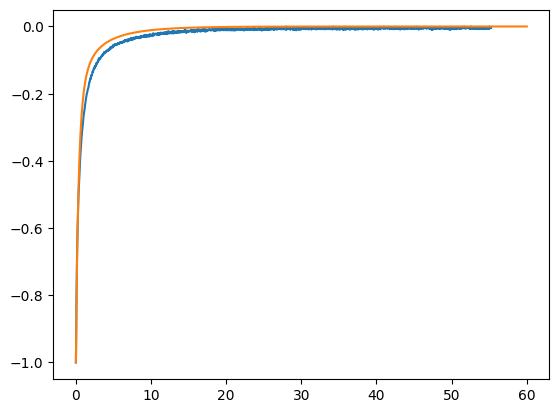

In [58]:
plt.plot(x_vals, scaled)
plt.plot(time_plt, scaled_time_curve(torch.from_numpy(time_plt), spec[:, 1]))
#plt.savefig(f"T1_time_curve_{field}_{temp}.eps")

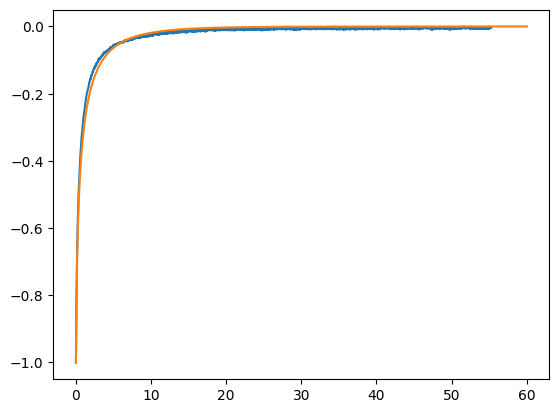

In [59]:
plt.plot(x_vals, scaled)
plt.plot(time_plt, scaled_time_curve(torch.from_numpy(time_plt), spec[:, 2]))

##### Теперь построим time-resolved

In [60]:
from population.temperature_dependance import profiles
from population import time_population, tr_utils, transform, mechanisms
import population
from population.temperature_dependance import rates
from importlib import reload
import copy

reload(population)
reload(mechanisms)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(spectra_manager)
reload(rates)
reload(utils)

reload(tr_utils)
reload(population.temperature_dependance.rates)
reload(population.temperature_dependance)
reload(rates)
reload(profiles)

<module 'population.temperature_dependance.profiles' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\population\\temperature_dependance\\profiles.py'>

Библиотека предоставляет различные профили температуры

In [61]:
t_short = 1.52
t_long = 70.00

t_short_start = torch.tensor(0.15 * 1e-3)
t_long_start =  torch.tensor(6 * 1e-3)

In [62]:
size = 200


start_time = t_long_start
delta_time = start_time + 1e-3 * 0.08

time = torch.linspace(start_time, t_long, size) * 1e-3


start_temp = torch.tensor(4.0)
start_profile = profiles.ConstantProfile(value=start_temp)

linear_decay_profile = profiles.LinearExpDecayProfile(
    slope=0.3, intercept=start_temp, start_time=start_time, end_time=start_time + 1e-3 * 0.08, decay_tau=1e-3 * 80)

start_segment = profiles.Segment(start_profile, torch.tensor(0.0),start_time)
linear_decay_segment = profiles.Segment(linear_decay_profile, start_time, time[-1] + (time[-1] - time[0]) / 1e4)


segments = [start_segment, linear_decay_segment]

piecewise_profile = profiles.PiecewiseProfile(segments)

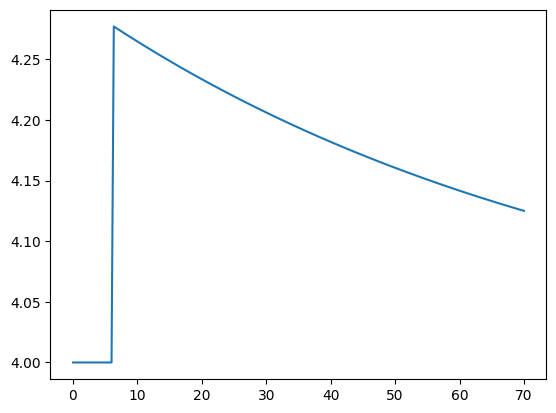

In [63]:
plt.plot(time.numpy() * 1e3, piecewise_profile(time).numpy())
plt.savefig("Temp_model_profile_short.eps")

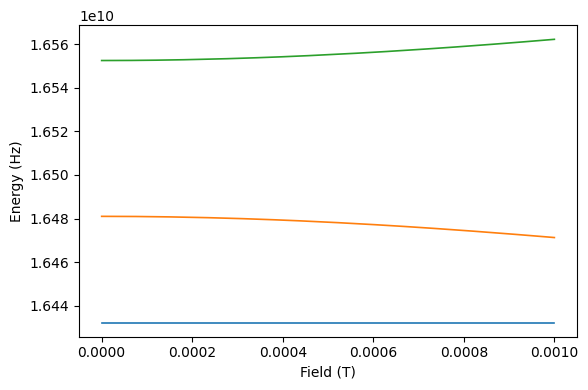

In [64]:
F, Gx, Gy, Gz = sample.get_hamiltonian_terms()
B = torch.linspace(0.0, 0.001, 200)
B = B[..., None, None]
orient_hams = F[0] + B *Gz[0] 
energies, vectors = torch.linalg.eigh(orient_hams)

import matplotlib.pyplot as plt
levels_plot.plot_energy_system(B, energies, vectors, levels=[1,2,3], saved_order=False)

zero_ham = F
zero_energies, zero_vectors = torch.linalg.eigh(zero_ham)

In [65]:
from math import sqrt

def get_levels_determination(vectors: torch.Tensor):
    
    Tx = (1 /sqrt(2)) * torch.tensor([1, 0.0, 0.0, -1.0], dtype=torch.complex64)
    Ty = (1.0j /sqrt(2)) * torch.tensor([1.0, 0.0, 0.0, 1.0], dtype=torch.complex64)
    Tz = (1 /sqrt(2)) * torch.tensor([0.0, 1, 1, 0.0], dtype=torch.complex64)
    T0 = (1 /sqrt(2)) * torch.tensor([0.0, -1, 1, 0.0], dtype=torch.complex64)
    
    basis_vectors = torch.stack([Tx, Ty, Tz, T0])
    basis_names = ["Tx", "Ty", "Tz", "T0"]
    
    closest_levels = []
    
    for i in range(vectors.shape[1]):
        eigenvector = vectors[:, i]
        eigenvector = eigenvector / torch.norm(eigenvector)
        overlaps = torch.abs(torch.sum(basis_vectors.conj() * eigenvector, dim=1))
        max_overlap_idx = torch.argmax(overlaps).item()
        closest_levels.append(basis_names[max_overlap_idx])
    return closest_levels

print(zero_energies[0]), print(zero_vectors[0]), print(get_levels_determination(zero_vectors[0]))

tensor([-4.9466e+10,  1.6432e+10,  1.6481e+10,  1.6552e+10])
tensor([[ 0.0000+0.j,  0.0000+0.j, -0.7071-0.j, -0.7071+0.j],
        [-0.7071+0.j, -0.7071+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.7071+0.j, -0.7071+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.7071+0.j, -0.7071+0.j]])
['T0', 'Tz', 'Tx', 'Ty']


(None, None, None)

In [66]:
def get_context(params):
    k_x, k_y, k_z, triplet_prob = params["k_x"], params["k_y"], params["k_z"], params["triplet_prob"]
    free_probs = [[0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, triplet_prob, 0.0],
                  [0.0, triplet_prob, 0.0, triplet_prob],
                  [0.0, 0.0, triplet_prob, 0.0]]
    free_probs = rates.RelaxationRateMatrix(free_probs)

    transform_probs =[
        [0, k_z, k_y, k_x],
        [k_z, 0, 0.0, 0.0],
        [k_y, 0.0, 0, 0.0],
        [k_x, 0.0, 0.0, 0]
    ]
    transform_probs = rates.RelaxationRateMatrix(transform_probs)

    context = mechanisms.TempDepContext(
        zero_field_vectors = zero_vectors,
        transform_probs = transform_probs,
        free_probs = free_probs,
        profile = piecewise_profile
    )
    
    return context


k_x = 19.40432703861892
k_y = 10.129719594771128
k_z = 9046.496879013306
triplet_prob = 98.78081991553208


zero_temp = torch.tensor(7.0)
k_x_temp = rates.PowerRate(k_x / zero_temp, power=1)
k_y_temp = rates.PowerRate(k_y / zero_temp, power=1)
k_z_temp = rates.PowerRate(k_z / zero_temp, power=1)
triplet_prob_temp = rates.PowerRate(triplet_prob / zero_temp, power=1)

params = {
 'k_x': k_x_temp,
 'k_y': k_y_temp,
 'k_z': k_z_temp,
 'triplet_prob': triplet_prob_temp
}


context = get_context(params)

In [67]:
temp_dep_populator = mechanisms.TempDepTrPopulation(solver=tr_utils.EvolutionVectorSolver.exponential_solver,
                                                    context=context, init_temp=start_temp)

freq = 9.820899 * 1e9
resonance_frequency = torch.tensor(freq)
fields_t1 = torch.linspace(0.340, 0.360, 200)


creator = spectra_manager.CoupledSpectraCreatorTimeResolved(freq=freq, sample=sample, populator=temp_dep_populator)

In [68]:
with torch.no_grad():
    fields_t1 = torch.linspace(0.340, 0.360, 200)
    spec = creator(sample, fields_t1, time=time)

In [69]:
fields_t1 = fields_t1.numpy() * 1000
answer = spec.numpy()
time = time.numpy() * 1e5 * 10

In [70]:
from matplotlib.colors import TwoSlopeNorm

def plot_heat_map(fields_t1: np.ndarray, time: np.ndarray, answer: np.ndarray):
    full_time = time[-1] 
    delta_field = fields_t1[1]- fields_t1[0]
    aspect = int(full_time / (2* delta_field)) + 10

    cmap = 'seismic'
    abs_max = abs(answer).max()
    norm = TwoSlopeNorm(
                vmin=-abs_max - 0.002,
                vcenter=0.,
                vmax=abs_max + 0.002
    )
    fig = plt.figure(dpi=200)
    img = plt.imshow(
            answer.T,
            norm=norm,
            cmap=cmap,
            interpolation='bicubic',
            extent=[0, full_time, fields_t1[0], fields_t1[-1] ],
            aspect=aspect / 100,
            origin = "lower"
            )

    plt.colorbar(img, cmap=cmap)
    fig.set_size_inches(8, 6)


def plot_kynetic(field: float, fields: np.ndarray, time: np.ndarray, answer: np.ndarray):
    
    def find_closest_uniform(field, fields):
        index = np.argmin(np.abs(fields - field))
        return index, fields[index]
    field_idx, field_value =  find_closest_uniform(field, fields)
    print("field", field_value)
    print("idx", field_idx)
    plt.plot(time, answer[field_idx])


    
    
def plot_fielddep(time_val: float, fields: np.ndarray, time: np.ndarray, answer: np.ndarray):
    def find_closest_uniform(time_val, time):
        index = np.argmin(np.abs(time - time_val))
        return index, time[index]
    
    time_idx, field_value =  find_closest_uniform(time_val, time)
    print("time", field_value)
    print("idx", time_idx)
    plt.plot(fields, answer[:, time_idx])

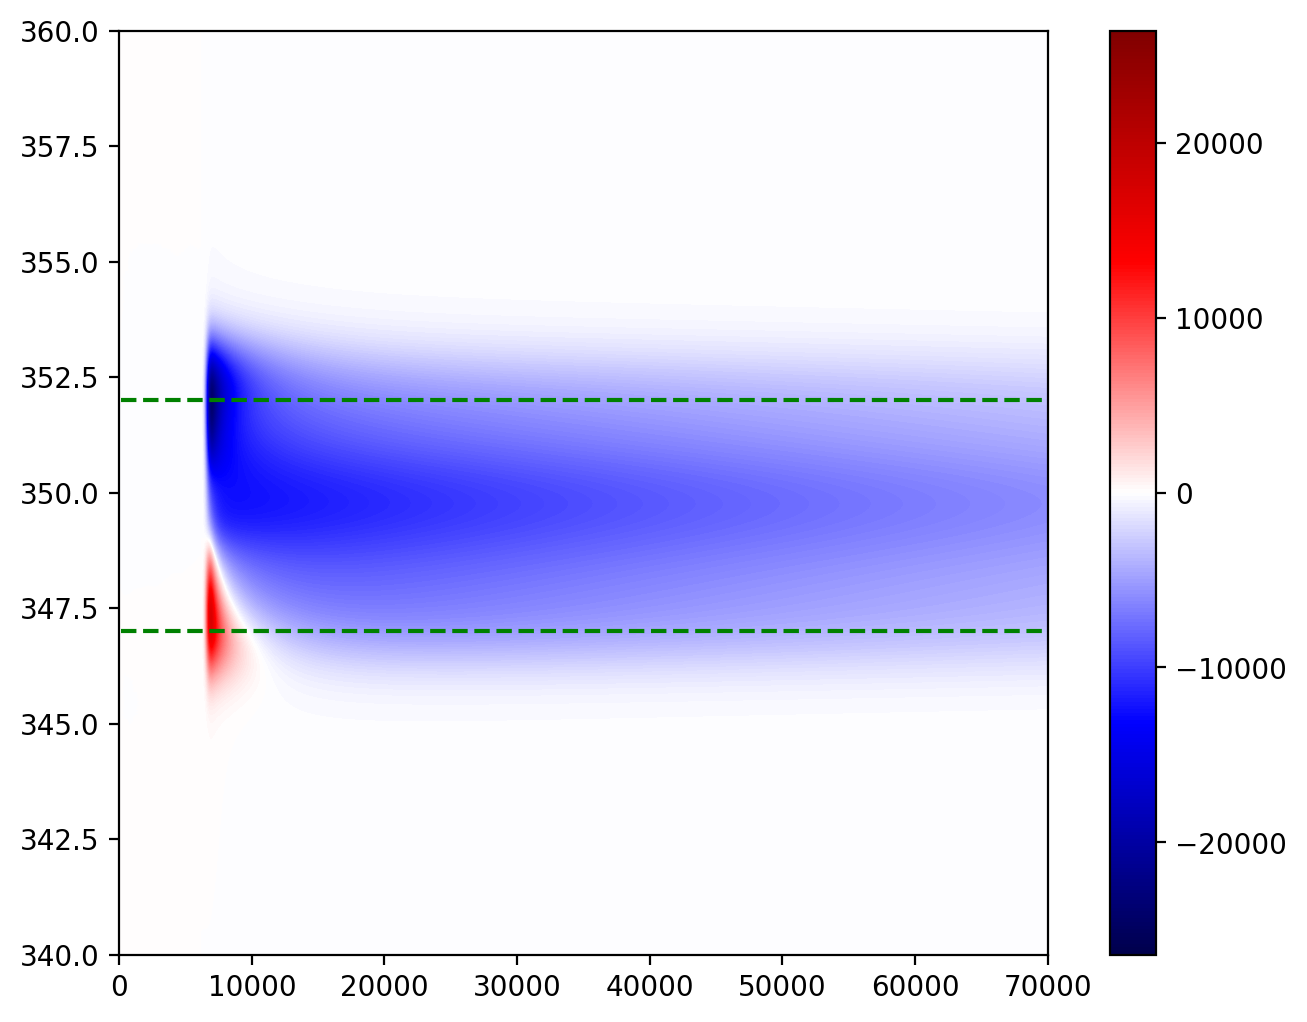

In [71]:
plot_heat_map(fields_t1, time, answer)
    
#plt.vlines(240, 342, 358, "b", linestyles="dashed")
#plt.vlines(170, 342, 358, "b", linestyles="dashed")
#plt.vlines(260, 342, 358, "r", linestyles="dashed")

plt.hlines(347, 100, time[-1], "g", linestyles="dashed")
plt.hlines(352, 100, time[-1], "g", linestyles="dashed")

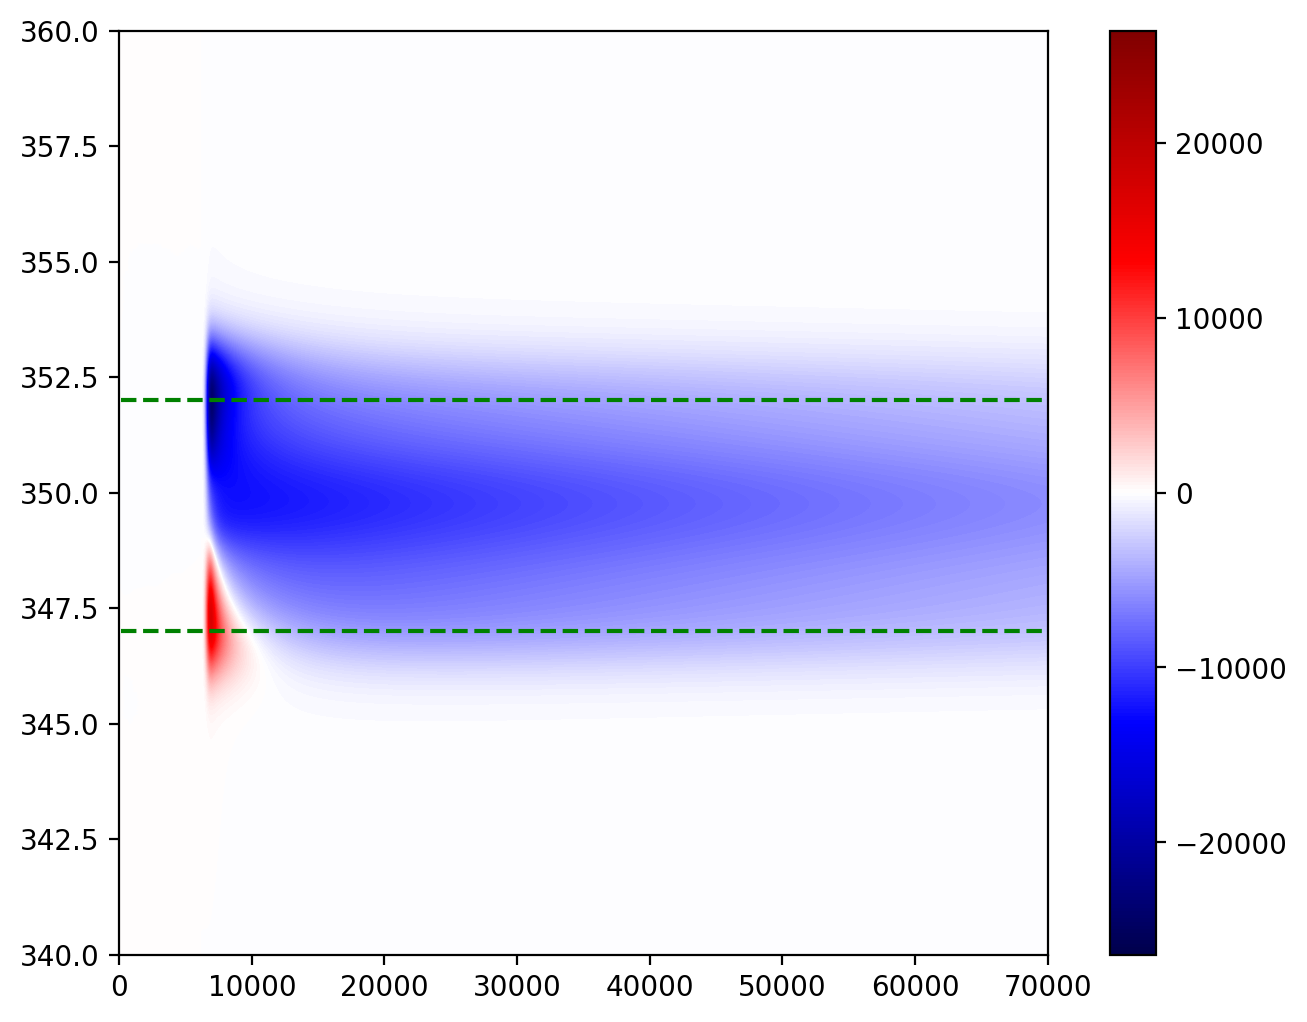

In [86]:
plot_heat_map(fields_t1, time, answer)
    
#plt.vlines(240, 342, 358, "b", linestyles="dashed")
#plt.vlines(170, 342, 358, "b", linestyles="dashed")
#plt.vlines(260, 342, 358, "r", linestyles="dashed")

plt.hlines(347, 100, time[-1], "g", linestyles="dashed")
plt.hlines(352, 100, time[-1], "g", linestyles="dashed")
plt.savefig("heat_map_model_4p0K_short_lavsan.eps")
plt.show()

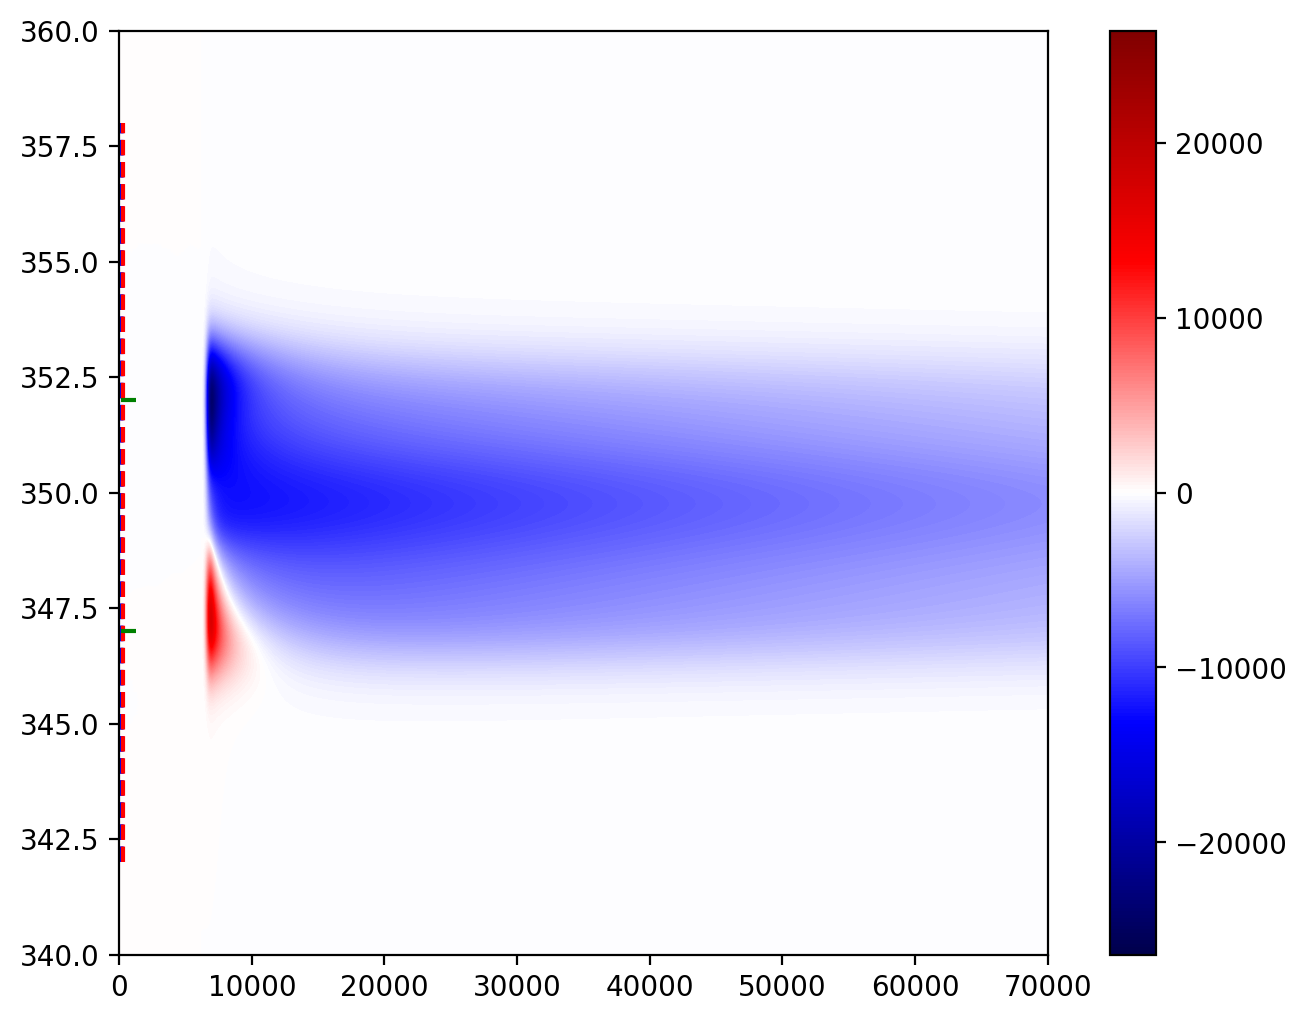

In [87]:
plot_heat_map(fields_t1, time, answer)
    
plt.vlines(240, 342, 358, "b", linestyles="dashed")
plt.vlines(170, 342, 358, "b", linestyles="dashed")
plt.vlines(260, 342, 358, "r", linestyles="dashed")

plt.hlines(347, 100, 1300, "g", linestyles="dashed")
plt.hlines(352, 100, 1300, "g", linestyles="dashed")
plt.show()

### THE END. Futher, my own computations
---------------------------------------------------------------

In [ ]:
answer.shape

In [ ]:
plot_fielddep(260, fields_t1, time, answer)
plt.show()

In [ ]:
plot_kynetic(347, fields_t1, time, answer)
plt.show()

In [ ]:
plot_kynetic(347, fields_t1, time, answer)

plt.savefig("model_4K_full_power_347mT_long.eps")
plt.show()


In [ ]:
plot_kynetic(352, fields_t1, time, answer)
plt.show()

In [ ]:
plot_kynetic(352, fields_t1, time, answer)
plt.show()

In [ ]:
k_x = 20.3723555477466
k_y = 145.4251328218196
k_z = 8787.46130349088
triplet_prob = 31.1356746538767
k_sum = k_x + k_y + k_z


zero_temp = torch.tensor(7.0)

k_x_temp = rates.PowerRate(k_x / zero_temp, power=1)
k_y_temp = rates.PowerRate(k_y / zero_temp, power=1)
k_z_temp = rates.PowerRate(k_z / zero_temp, power=1)
k_sum_temp = rates.PowerRate(k_sum / zero_temp, power=1)

triplet_prob_temp = rates.PowerRate(triplet_prob / zero_temp, power=1)

def get(time, temp, *args):
    k_x, k_y, k_z, triplet_prob,  = args
    temp = torch.tensor([temp])
    
    free_probs = [[0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, triplet_prob, 0.0],
                  [0.0, triplet_prob, 0.0, triplet_prob],
                  [0.0, 0.0, triplet_prob, 0.0]]
    free_probs = rates.RelaxationRateMatrix(free_probs)(temp)

    free_probs_tr =[
            [0, k_z, k_y, k_x],
            [k_z, 0, 0.0, 0.0],
            [k_y, 0.0, 0, 0.0],
            [k_x, 0.0, 0.0, 0]
        ]

    free_probs_tr = rates.RelaxationRateMatrix(free_probs_tr)(temp)
    config = {"zero_energies": zero_energies.squeeze(),
              "zero_vectors": zero_vectors.squeeze(),
               "free_probs": free_probs.squeeze(),
               "free_probs_transform": free_probs_tr.squeeze(),
              "time": time
                 }
    return config

In [ ]:
temp = torch.tensor([4.2])

In [ ]:
(1 / k_sum_temp(temp)) * 1000 * 1000

In [ ]:
max_times_idx = answer.argmax(axis=1)
max_times = time[max_times_idx]
plt.plot(fields_t1, max_times - 200)

In [ ]:
min_times_idx = answer.argmin(axis=1)
min_times = time[min_times_idx]
plt.plot(fields_t1, min_times - 200)

### Проделаем следующий алгоритм 
1) Построим кривые релаксации
2) Построим фит для времени подъёма и времени спада
3) Повторим процедуру для разных kx, ky, kz, triplet_probs
4) Построим завивимость времён релаксации от kx, ky, kz, triplet_probs

In [ ]:
from population.temperature_dependance import profiles
from population import time_resolved_population, tr_utils, transform
import population
from population.temperature_dependance import rates
from importlib import reload
import copy


reload(population)
reload(time_resolved_population)
reload(levels_plot)
reload(transitions_plot)
reload(rates)


reload(tr_utils)
reload(profiles)

In [ ]:
best_params_cw = {'g_factor': 2.0064026806055115,
 'g_strain': 0.0057826633838925995,
 'D': 88.95762784927365,
 'D_str': 70.71112429094259,
 'E_D_attitude': 0.3327962487663032,
 'h_strain': 8.08377174375672}
best_values_cw = best_params_cw.values()

mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, np.pi), initial_grid_frequency=15, interpolate=False)
rotation_matrices = mesh.create_rotation_matrices()
powder = build_powder(rotation_matrices, *best_values_cw)

In [ ]:
start_time = torch.tensor(0.15 * 1e-3)
delta_time = start_time + 1e-3 * 0.08
start_temp = torch.tensor(4.0)

start_profile = profiles.ConstantProfile(value=start_temp)
linear_decay_profile = profiles.LinearExpDecayProfile(
    slope=0.3, intercept=start_temp, start_time=start_time, end_time=start_time + 1e-3 * 0.08, decay_tau=1e-3 * 20)
start_segment = profiles.Segment(start_profile, torch.tensor(0.0),start_time)
linear_decay_segment = profiles.Segment(linear_decay_profile, start_time, torch.tensor(1.0))
segments = [start_segment, linear_decay_segment]
piecewise_profile = profiles.PiecewiseProfile(segments)

In [ ]:
def set_probabilities(time, k_x, k_y, k_z, triplet_prob):
    zero_temp = torch.tensor(4.0)
    k_x_temp = rates.PowerRate(k_x / zero_temp, power=1)
    k_y_temp = rates.PowerRate(k_y / zero_temp, power=1)
    k_z_temp = rates.PowerRate(k_z / zero_temp, power=1)
    triplet_prob_temp = rates.PowerRate(triplet_prob / zero_temp, power=1)
    
    args = (k_x_temp, k_y_temp, k_z_temp, triplet_prob_temp)
    
    def build_config(time, *args):
        k_x, k_y, k_z, triplet_prob,  = args

        free_probs = [[0.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, triplet_prob, 0.0],
                      [0.0, triplet_prob, 0.0, triplet_prob],
                      [0.0, 0.0, triplet_prob, 0.0]]
        free_probs = rates.RelaxationRateMatrix(free_probs)

        free_probs_tr =[
            [0, k_z, k_y, k_x],
            [k_z, 0, 0.0, 0.0],
            [k_y, 0.0, 0, 0.0],
            [k_x, 0.0, 0.0, 0]
        ]

        free_probs_tr = rates.RelaxationRateMatrix(free_probs_tr)
        config = {"zero_energies": zero_energies,
                  "zero_vectors": zero_vectors,
                   "free_probs": free_probs,
                   "free_probs_transform": free_probs_tr,
                   "time": time,
                  "profile": piecewise_profile
                     }
        return config
    config = build_config(time, *args)
    return config


def get_answer(time, k_x, k_y, k_z, triplet_prob):
    config = set_probabilities(time, k_x, k_y, k_z, triplet_prob)
    
    time_res_populator = T1Population(start_temp = start_temp, config=config)
    intensity_calculator = spectra_manager.TimeResolvedIntensitiesCalculator(
        spin_system_dim=powder.spin_system.dim, populator=time_res_populator
    )
    spectra_creator = spectra_manager.CoupledSpectraCreatorTimeResolved(powder.spin_system.dim, tuple(), mesh, intensity_calculator=intensity_calculator)

    freq = 9.820899 * 1e9
    resonance_frequency = torch.tensor(freq)

    with torch.no_grad():
        #fields_t1 = torch.tensor([330, 333, 334, 335, 336, 337, 338, 339.4, 339.7, 350]) / 1000
        fields_t1 = torch.linspace(0.340, 0.360, 200)
        answer = spectra_creator(powder, resonance_frequency, fields_t1)
        
    fields_t1 = fields_t1.numpy() * 1000
    answer = answer.numpy()
    time = time.numpy() * 1e5 * 10
    return time, fields_t1, answer

def get_curves(time, result):
    zero_time = 250
    zero_idx = np.argmin(np.abs(time - zero_time))
    
    max_idx = np.argmax(result)
    min_idx = np.argmin(result)
    
    time_curve_1 = time[zero_idx: max_idx] - zero_time
    result_curve_1 = result[zero_idx: max_idx]
    
    time_curve_2 = time[max_idx: min_idx] - time[max_idx]
    result_curve_2 = result[max_idx: min_idx]
    
    return (time_curve_1, result_curve_1), (time_curve_2, result_curve_2)


def get_time_exp_curves(k_x, k_y, k_z, triplet_pro, mode):
    size = 1500
    if mode == "short":
        time = torch.linspace(0.0, 3.0, size) * 1e-3
        time, fields_t1, answer = get_answer(time, k_x, k_y, k_z, triplet_prob)
        (time, result), _ = get_curves(time, answer[70])
            
    else:
        time = torch.linspace(0.0, 70, size) * 1e-3
        time, fields_t1, answer = get_answer(time, k_x, k_y, k_z, triplet_prob)
        _, (time, result) = get_curves(time, answer[70])
        
    old_max = np.max(result, axis=-1, keepdims=True)
    old_min = np.min(result, axis=-1, keepdims=True)

    scaled = (result - old_min) / (old_max - old_min) * 2 - 1
    return time, scaled
    

In [ ]:
F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
B = torch.linspace(0.0, 0.001, 200)
B = B[..., None, None]
orient_hams = F[0] + B *Gz[0] 
energies, vectors = torch.linalg.eigh(orient_hams)

import matplotlib.pyplot as plt
levels_plot.plot_energy_system(B, energies, vectors, levels=[1,2,3], saved_order=False)

zero_ham = F
zero_energies, zero_vectors = torch.linalg.eigh(zero_ham)

In [ ]:
import random

k_x = 20.3723555477466
k_y = 145.4251328218196
k_z = 8787.46130349088
triplet_prob = 31.1356746538767
k_sum = k_x + k_y + k_z

class KRandomizer:
    def __init__(self, 
                 k_x_range=(5, 500), 
                 k_y_range=(5, 500), 
                 k_z_range=(900, 10000),
                 triplet_prob_range=(5, 500)):
        """
        Initialize the randomizer with ranges for each parameter.
        
        Args:
            k_x_range: tuple (min, max) for k_x values
            k_y_range: tuple (min, max) for k_y values  
            k_z_range: tuple (min, max) for k_z values
            triplet_prob_range: tuple (min, max) for triplet_prob values
        """
        self.k_x_range = k_x_range
        self.k_y_range = k_y_range
        self.k_z_range = k_z_range
        self.triplet_prob_range = triplet_prob_range
    
    def generate_random_values(self):
        """
        Generate random k_x, k_y, k_z values and calculate k_sum and triplet_probs.
        
        Returns:
            dict: Dictionary containing k_x, k_y, k_z, k_sum, and triplet_probs
        """
        # Generate random values within specified ranges
        k_x = random.uniform(*self.k_x_range)
        k_y = random.uniform(*self.k_y_range)
        k_z = random.uniform(*self.k_z_range)
        
        # Calculate k_sum
        k_sum = k_x + k_y + k_z
        
        # Generate random triplet_probs
        triplet_prob = random.uniform(*self.triplet_prob_range)
        
        return {
            'k_x': k_x,
            'k_y': k_y,
            'k_z': k_z,
            'k_sum': k_sum,
            'triplet_prob': triplet_prob
        }

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

def exp_fit(x_vals, shift, amplitude, tau):
    return shift + amplitude * np.exp(-x_vals / tau)


In [ ]:
from tqdm import tqdm


def get_tau_short(k_x, k_y, k_z, triplet_prob):
    model = Model(exp_fit)
    
    
    time, result = get_time_exp_curves(k_x, k_y, k_z, triplet_prob, mode="short")
    params = model.make_params(
        shift=0.5, amplitude=1, tau=1e2,
    )
    
    params['amplitude'].max = 15
    params['amplitude'].min = -15
    params['tau'].min = 10
    params['tau'].max = 1e3
    params['shift'].min = -15
    params['shift'].max = 15

    fit_result = model.fit(result, params, x_vals=time, method="dual_annealing")
    tau = fit_result.params["tau"].value
    return tau

def get_tau_long(k_x, k_y, k_z, triplet_prob):
    model = Model(exp_fit)
    
    
    time, result = get_time_exp_curves(k_x, k_y, k_z, triplet_prob, mode="long")
    params = model.make_params(
        shift=0.5, amplitude=1, tau=1e2,
    )
    
    params['amplitude'].max = 5
    params['amplitude'].min = 0.0
    params['tau'].min = 100
    params['tau'].max = 4e4
    params['shift'].min = -5
    params['shift'].max = 1

    fit_result = model.fit(result, params, x_vals=time, method="dual_annealing")
    tau = fit_result.params["tau"].value
    return tau


In [ ]:
n = 100
kn_rand = KRandomizer()
tau_values = []
k_values = []
k_square = []
k_z_lst = []
for _ in tqdm(range(n)):
    try:
        random_values = kn_rand.generate_random_values()

        k_sum = random_values["k_sum"]
        random_values.pop("k_sum")
        k_x = random_values["k_x"]
        k_y = random_values["k_y"]
        k_z = random_values["k_z"]

        ksq = k_x**2 + k_y**2 + k_z**2
        ksq = ksq ** 0.5
        tau = get_tau_short(**random_values)
    except:
        pass
    else:
        tau_values.append(tau)
        k_values.append(k_sum / 1e6)
        k_square.append(ksq / 1e6)
        k_z_lst.append(k_z / 1e6)
    
k_values_short = np.array(k_values)
tau_values_short = np.array(tau_values)
k_square_short = np.array(k_square)
k_z_lst = np.array(k_z_lst)

In [ ]:
k_values_short = np.array(k_values)
tau_values_short = np.array(tau_values)
k_square_short = np.array(k_square)
T_theory = 1 /(2 *  k_values_short)
T_theory = T_theory * 7 / 4

attitude = tau_values_short / T_theory

In [ ]:
plt.scatter(T_theory[attitude < 1.50], attitude[attitude < 1.50], s=3.3)
plt.savefig("relaxation_attitude-kojij.eps")

In [ ]:
T_theory = 1 /(2 *  k_values_short)
attitude = tau_values_short / T_theory
mask = attitude > 0.1
mask = mask * (attitude < 1.0)

plt.scatter(tau_values_short[mask], attitude[mask], s=2.3)
plt.savefig("relaxation_attitude-jkjhj.eps")

In [ ]:
T_theory = 1 /(2 *  k_values_short)
attitude = tau_values_short / T_theory
mask = attitude > 0.1
mask = mask * (attitude < 1.0)

plt.scatter(tau_values_short[mask], attitude[mask], s=2.3)


In [ ]:
sum(mask)

In [ ]:
n = 12_000
kn_rand = KRandomizer()
tau_values = []
k_values = []
k_square = []
k_z_lst = []
k_x_lst = []
k_y_lst = []
triplet_probs = []
for _ in tqdm(range(n)):

    random_values = kn_rand.generate_random_values()

    k_sum = random_values["k_sum"]
    random_values.pop("k_sum")
    k_x = random_values["k_x"]
    k_y = random_values["k_y"]
    k_z = random_values["k_z"]
    triplet_prob = random_values["triplet_prob"]

    ksq = k_x**2 + k_y**2 + k_z**2
    ksq = ksq ** 0.5
    tau = get_tau_long(**random_values)


In [ ]:
n = 12_000
kn_rand = KRandomizer()
tau_values = []
k_values = []
k_square = []
k_z_lst = []
k_x_lst = []
k_y_lst = []
triplet_probs = []
for _ in tqdm(range(n)):
    try:
        random_values = kn_rand.generate_random_values()

        k_sum = random_values["k_sum"]
        random_values.pop("k_sum")
        k_x = random_values["k_x"]
        k_y = random_values["k_y"]
        k_z = random_values["k_z"]
        triplet_prob = random_values["triplet_prob"]

        ksq = k_x**2 + k_y**2 + k_z**2
        ksq = ksq ** 0.5
        tau = get_tau_long(**random_values)
    except:
        pass
    else:
        tau_values.append(tau)
        k_values.append(k_sum / 1e6)
        k_square.append(ksq / 1e6)
        k_z_lst.append(k_z / 1e6)
        k_y_lst.append(k_y / 1e6)
        k_x_lst.append(k_x / 1e6)
        triplet_probs.append(triplet_prob / 1e6)

In [ ]:
k_values_long = np.array(k_values)
tau_values_long = np.array(tau_values)
#prob_values_long = np.array(prob_values)
k_square = np.array(k_square)
k_z_lst = np.array(k_z_lst)
k_y_lst = np.array(k_y_lst)
k_x_lst = np.array(k_x_lst)
triplet_probs = np.array(triplet_probs)

In [ ]:
k_perp = (k_values_long**2 - k_square)

In [ ]:
#T_theory = 1 / (2 * np.sqrt( * k_square))
k_eff = k_z_lst
T_theory = 1 / (2 * k_eff)

attitude = tau_values_long / T_theory
mask = tau_values_long < 1e3
mask = mask * (attitude < 1e15)

In [ ]:
plt.scatter(tau_values_long[mask], attitude[mask], s=2.3)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = np.column_stack([k_x_lst[mask] + k_y_lst[mask], k_z_lst[mask], triplet_probs[mask]])
y = tau_values_long[mask]

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

y_pred = model.predict(X)

In [ ]:
plt.scatter(tau_values_long[mask], tau_values_long[mask] / y_pred , s=2.3)

In [ ]:
y_pred.shape

In [ ]:
coefficients = model.coef_

In [ ]:
coefficients